In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from util import cap_outliers_percentile
from models.random_forest import RandomForest
from models.xg_boost import XGBoost
from models.light_gbm import LightGBM
import shap

In [2]:
seed = 1000
np.random.seed(seed)
random.seed(seed)

### Load Data

In [3]:
path = kagglehub.dataset_download("neurocipher/heartdisease")
print("Files:", os.listdir(path))

csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

Files: ['Heart_Disease_Prediction.csv']


In [4]:
df.head(3)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence


### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [6]:
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


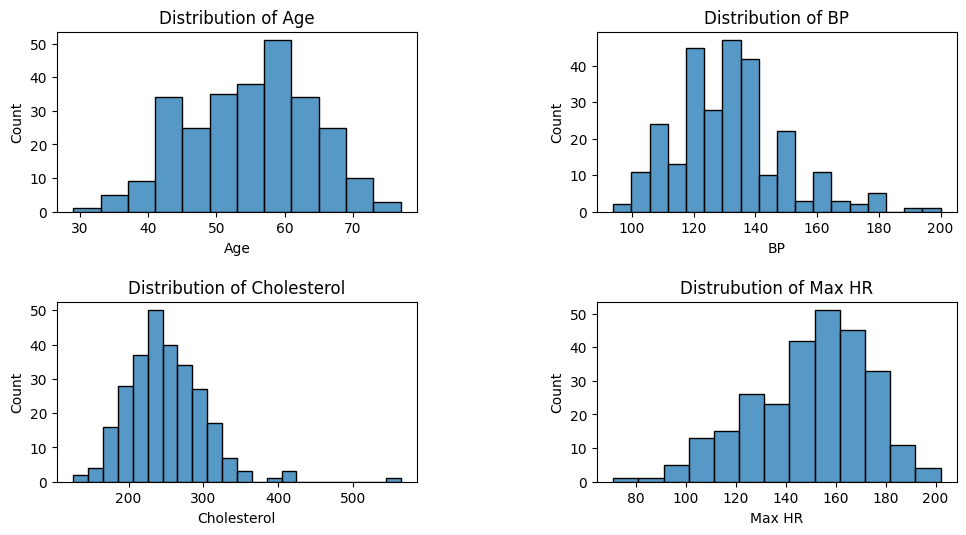

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
sns.histplot(df['Age']).set(title='Distribution of Age')

plt.subplot(2,2,2)
sns.histplot(df['BP']).set(title='Distribution of BP')

plt.subplot(2,2,3)
sns.histplot(df['Cholesterol']).set(title='Distribution of Cholesterol')

plt.subplot(2,2,4)
sns.histplot(df['Max HR']).set(title='Distrubution of Max HR')

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

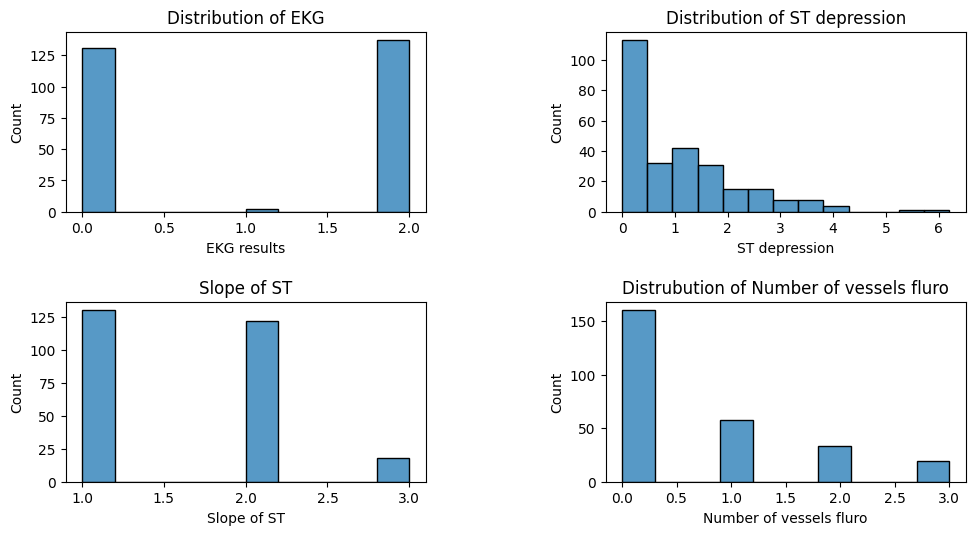

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
sns.histplot(df['EKG results']).set(title='Distribution of EKG')

plt.subplot(2,2,2)
sns.histplot(df['ST depression']).set(title='Distribution of ST depression')

plt.subplot(2,2,3)
sns.histplot(df['Slope of ST']).set(title='Slope of ST')

plt.subplot(2,2,4)
sns.histplot(df['Number of vessels fluro']).set(title='Distrubution of Number of vessels fluro')

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

In [9]:
print(list(df.columns))

['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']


### Check for missing values

In [10]:
df.isnull().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

### Remove outliers

In [11]:
# Remove outliers using Winsorization(percentile capping)
continuos_vars = ['Age', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
df = cap_outliers_percentile(df, continuos_vars)

In [12]:
# replace target variable with 1s and 0s
df["Heart Disease"] = (df["Heart Disease"].replace({"Presence": 1, "Absence": 0}))

C:\Users\syarn\AppData\Local\Temp\ipykernel_25980\1406989344.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Heart Disease"] = (df["Heart Disease"].replace({"Presence": 1, "Absence": 0}))


### Correlation Matrix

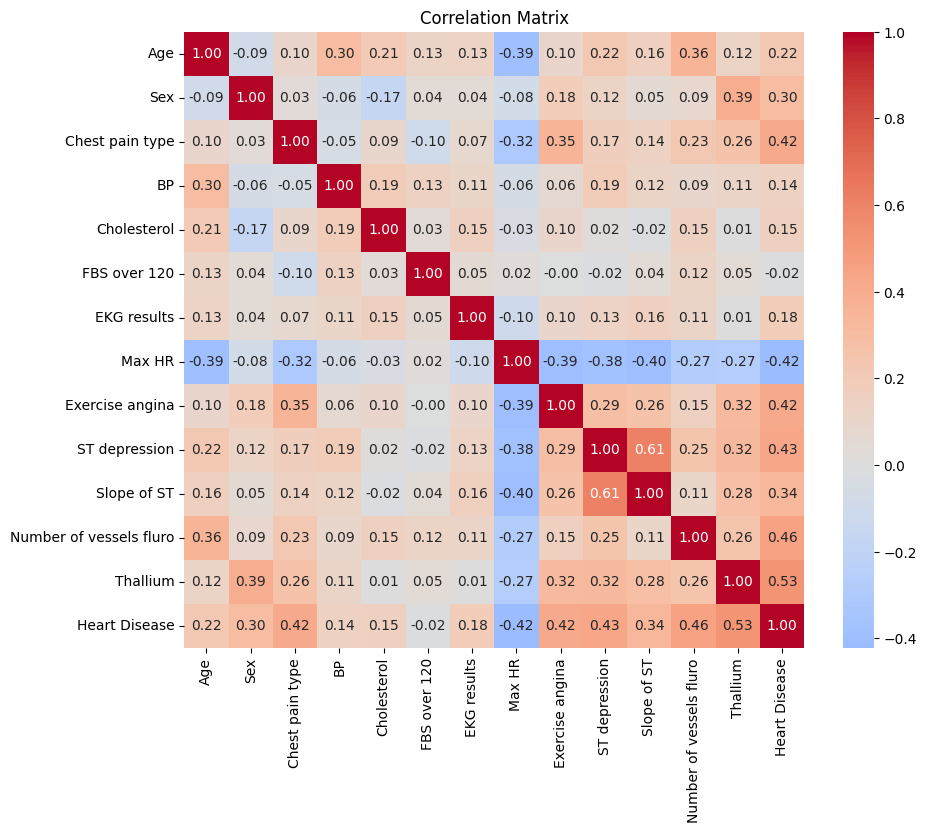

In [13]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix")
plt.show()

### Check for class imbalance in the target variable

There are slightly more people without heart disease than people without it

In [14]:
class_dist = pd.DataFrame({
    "count": df['Heart Disease'].value_counts(),
    "percentage": (df['Heart Disease'].value_counts(normalize=True) * 100).round(2)
})

class_dist

,count,percentage
Heart Disease,,
0,150,55.56
1,120,44.44


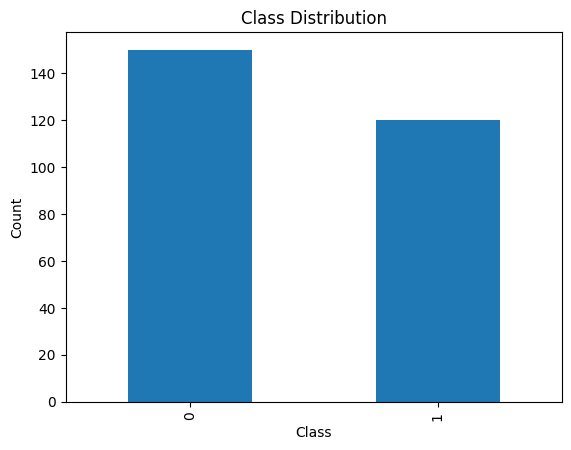

In [15]:
df['Heart Disease'].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

### Split Data into Train, Validation, Test

In [16]:
pred_cols = ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 
             'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
target_col = "Heart Disease"

X = df[pred_cols]
y = df[target_col]

# 70% train+val, 30% test
X_temp, X_test, y_temp, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size=0.30, 
                                                  random_state=seed, 
                                                  stratify=y)

# Split train+val into train and validation (70/30 split of remaining)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.30, random_state=seed,stratify=y_temp)


## Train Models

#### Random Forest

In [17]:
rf = RandomForest()
best_params = rf.tune_classifier(X=X_train, y=y_train)

tuned_rf_clf, best_params = rf.fit_classifier(X=X_train, y=y_train, best=best_params)
y_pred = tuned_rf_clf.predict_proba(X_val)
rf_auc_val = rf.compute_auc(y_val, y_pred[:, 1])
print(f"Validation AUC ROC: {rf_auc_val}")

100%|██████████| 50/50 [00:45<00:00,  1.11trial/s, best loss: -0.911984126984127] 
Validation AUC ROC: 0.88875


#### XGBoost

In [18]:
xg = XGBoost()
best_params = xg.tune_classifier(X=X_train, y=y_train)

tuned_xg_clf, best_params = xg.fit_classifier(X=X_train, y=y_train, best=best_params)
y_pred = tuned_xg_clf.predict_proba(X_val)
xg_auc_val = xg.compute_auc(y_val, y_pred[:, 1])
print(f"Validation AUC ROC: {xg_auc_val}")

100%|██████████| 50/50 [00:06<00:00,  8.06trial/s, best loss: -0.9074242424242425]
Validation AUC ROC: 0.8281249999999999


#### LightGBM

In [19]:
lgbm = LightGBM()
best_params = lgbm.tune_classifier(X=X_train, y=y_train)

tuned_lgbm_clf, best_params = lgbm.fit_classifier(X=X_train, y=y_train, best=best_params)
y_pred = tuned_lgbm_clf.predict_proba(X_val)
lgbm_auc_val = lgbm.compute_auc(y_val, y_pred[:, 1])
print(f"Validation AUC ROC: {lgbm_auc_val}")

100%|██████████| 50/50 [00:19<00:00,  2.62trial/s, best loss: -0.9018759018759018]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

## Final Model

Random Forest model had the best performance on the validation set with a AUC of <b> 0.88875 </b>therefore was selected as the final model 

In [20]:
y_pred = tuned_rf_clf.predict_proba(X_test)
rf_auc_test = rf.compute_auc(y_test, y_pred[:, 1])
print(f"Validation AUC ROC: {rf_auc_test}")

Validation AUC ROC: 0.928395061728395


The AUC of the test set is <b>0.928395061728395 </b>

<b> The most important predictors for heart disease were Number of vessels fluro, Chest pain type, ST depression, Thalium, and Max HR </b>

C:\Users\syarn\AppData\Local\Temp\ipykernel_25980\1341001193.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test)


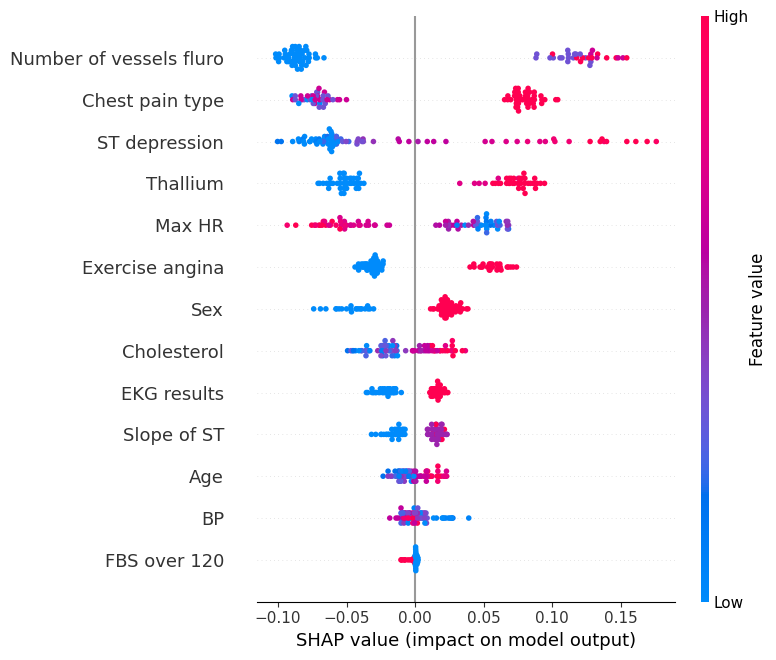

In [21]:
# 2. Create a SHAP explainer (TreeExplainer is efficient for tree models)
explainer = shap.TreeExplainer(tuned_rf_clf)

# 3. Calculate SHAP values
shap_values = explainer(X_test) 

shap.summary_plot(shap_values[:, :, 1], X_test)